In [39]:
from qdclib import qdccirq
from qdclib import spinmodels
from openfermion import ops, transforms
from qdclib.qdcutils import perp_norm, logsweep_params

L = 7
K = 2
for JvB in [0.2, 1, 5]:
    print(f'System: L = {L}, J/B = {JvB}')
    system = spinmodels.TFIMChain(L, JvB, 1)
    system.normalize()
    print(f'    hamiltonian spread = 2')
    print(f'    GS gap = ε_min = {system.ground_state_gap()}')
    
    for K in [2]:
        print(f'> LogSweep protocol with K = {K}:')

        ### from qdccirq.logsweep_protocol:
        coupl_potentials = [
            transforms.get_sparse_operator(ops.QubitOperator((i, P),), n_qubits=L)
            for i in range(L) for P in ('X', 'Y', 'Z')
        ]
        e_max_transitions = max(perp_norm(cp, system.get_sparse_hamiltonian())
                                for cp in coupl_potentials)

        print(f'    maximum transition energy = {e_max_transitions}')

        # define e_min, e_max using perp_norm on sparse matrices
        e_min = system.ground_state_gap()
        e_max = e_max_transitions

        # define delta_factor
        h = e_max / e_min
        R = np.log(h) * ((1 - h) / (2 * (1 + h)) + np.log(2 * h / (1 + h)))
        delta_factor = np.log(K * 8 / R) / 2 / np.pi

        print(f'    delta factor = delta_factor')

        epsilon_list, delta_list = logsweep_params(e_min, e_max, K, delta_factor)


        ### from qdccirq.energy_sweep_protocol
        eigvals, eigvecs = system.eig()
        spectral_spread = eigvals[-1] - eigvals[0]


        ### adapted from qdccirq.weak_coupling_step
        trotter_factor = 2
        trotter_number_f = lambda delta: int(
            trotter_factor * np.sqrt(1 + (spectral_spread) ** 2 / (np.pi * delta) ** 2)
        )
        trotter_number_list = [trotter_number_f(delta)*len(coupl_potentials) for delta in delta_list]
        print(f'    total number of trotter steps: {np.sum(trotter_number_list)}', flush=True)
        
#         circuit = qdccirq.logsweep_protocol(system, K)
#         print(f'    circuit depth = {len(circuit)}')
#         gates = 0
#         for _ in circuit.all_operations():
#             gates +=1
#         print(f'    number of gates = {gates}', flush = True)

    print()

System: L = 7, J/B = 0.2
    hamiltonian spread = 2
    GS gap = ε_min = 0.23165622454505297
> LogSweep protocol with K = 2:
    maximum transition energy = 0.3051041444668817
    delta factor = delta_factor
    total number of trotter steps: 1323
    circuit depth = 7980
    number of gates = 30471

System: L = 7, J/B = 1
    hamiltonian spread = 2
    GS gap = ε_min = 0.048806463119834165
> LogSweep protocol with K = 2:
    maximum transition energy = 0.5220327835387703
    delta factor = delta_factor
    total number of trotter steps: 1260
    circuit depth = 7602
    number of gates = 29022

System: L = 7, J/B = 5
    hamiltonian spread = 2
    GS gap = ε_min = 0.27126598015086945
> LogSweep protocol with K = 2:
    maximum transition energy = 0.6600588566377121
    delta factor = delta_factor
    total number of trotter steps: 420
    circuit depth = 2562
    number of gates = 9702



In [3]:
from qdclib import qdccirq
from qdclib import spinmodels
from openfermion import ops, transforms
from qdclib.qdcutils import perp_norm, logsweep_params

def total_trotter_steps(L, JvB, K):
    
    ### from qdccirq.logsweep_protocol
    
    system = spinmodels.TFIMChain(L, JvB, 1)
    system.normalize()
    coupl_potentials = [
        transforms.get_sparse_operator(ops.QubitOperator((i, P),), n_qubits=L)
        for i in range(L) for P in ('X', 'Y', 'Z')
    ]
    e_max_transitions = max(perp_norm(cp, system.get_sparse_hamiltonian())
                            for cp in coupl_potentials)
    # define e_min, e_max using perp_norm on sparse matrices
    e_min = system.ground_state_gap()
    e_max = e_max_transitions

    # define delta_factor
    h = e_max / e_min
    R = np.log(h) * ((1 - h) / (2 * (1 + h)) + np.log(2 * h / (1 + h)))
    delta_factor = np.log(K * 8 / R) / 2 / np.pi
    
    epsilon_list, delta_list = logsweep_params(e_min, e_max, K, delta_factor)

    
    ### from qdccirq.energy_sweep_protocol
    
    eigvals, eigvecs = system.eig()
    spectral_spread = eigvals[-1] - eigvals[0]

    
    ### adapted from qdccirq.weak_coupling_step
    trotter_factor = 2
    trotter_number_f = lambda delta: int(
        trotter_factor * np.sqrt(1 + (spectral_spread) ** 2 / (np.pi * delta) ** 2)
    )
    return sum((trotter_number_f(delta)*len(coupl_potentials) for delta in delta_list))

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# vs L, K=2

In [5]:
JvBlist = [.2, 1, 5] 
Llist = np.arange(2, 13)
K = 2

tts_lists_vsL = [[total_trotter_steps(L, JvB, K) for JvB in JvBlist] for L in Llist]

6s exec for arange(2, 10)

50s exec for arange(2, 12)

Text(0, 0.5, 'tot trotter steps')

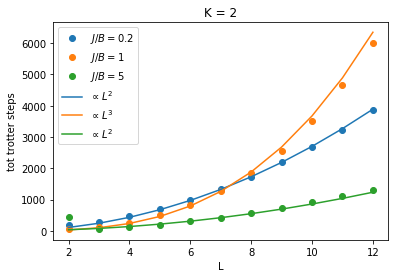

In [6]:
plt.title(f'K = {K}')
plt.plot(Llist, tts_lists_vsL, 'o', label=' ')
plt.gca().set_prop_cycle(None)
plt.plot(Llist, Llist**2 / Llist[5]**2 * tts_lists_vsL[5][0], label='$\propto L^2$')
plt.plot(Llist, Llist**3 / Llist[5]**3 * tts_lists_vsL[5][1], label='$\propto L^3$')
plt.plot(Llist, Llist**2 / Llist[5]**2 * tts_lists_vsL[5][2], label='$\propto L^2$')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, [f'$J/B = {JvB}$' for JvB in JvBlist] + l[3:])
plt.xlabel('L')
plt.ylabel('tot trotter steps')

# vs L, K=10

In [86]:
JvBlist = [.2, 1, 5] 
Llist = np.arange(2, 11)
K = 10

tts_lists_K10 = [[total_trotter_steps(L, JvB, K) for JvB in JvBlist] for L in Llist]

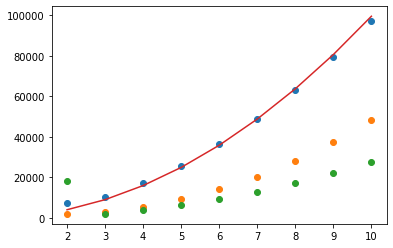

In [87]:
plt.title(f'K = {K}')
plt.plot(Llist, tts_lists_K10_vsL, 'o', label=' ')
plt.gca().set_prop_cycle(None)
plt.plot(Llist, Llist**2 / Llist[5]**2 * tts_lists_K10_vsL[5][0], label='$\propto L^2$')
plt.plot(Llist, Llist**3 / Llist[5]**3 * tts_lists_K10_vsL[5][1], label='$\propto L^3$')
plt.plot(Llist, Llist**2 / Llist[5]**2 * tts_lists_K10_vsL[5][2], label='$\propto L^2$')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, [f'$J/B = {JvB}$' for JvB in JvBlist] + l[3:])
plt.xlabel('L')
plt.ylabel('tot trotter steps')

# vs K, L = 5 

In [6]:
JvBlist = [.2, 1, 5] 
L = 5
Klist = np.arange(2, 80, 4)

tts_lists_vsK = [[total_trotter_steps(L, JvB, K) for JvB in JvBlist] for K in Klist]

In [7]:
def Rfunc(L, JvB):
    system = spinmodels.TFIMChain(L, JvB, 1)
    system.normalize()
    coupl_potentials = [
        transforms.get_sparse_operator(ops.QubitOperator((i, P),), n_qubits=L)
        for i in range(L) for P in ('X', 'Y', 'Z')
    ]
    e_max_transitions = max(perp_norm(cp, system.get_sparse_hamiltonian())
                            for cp in coupl_potentials)
    # define e_min, e_max using perp_norm on sparse matrices
    e_min = system.ground_state_gap()
    e_max = e_max_transitions

    # define delta_factor
    h = e_max / e_min
    return np.log(h) * ((1 - h) / (2 * (1 + h)) + np.log(2 * h / (1 + h)))

Text(0, 0.5, 'tot trotter steps')

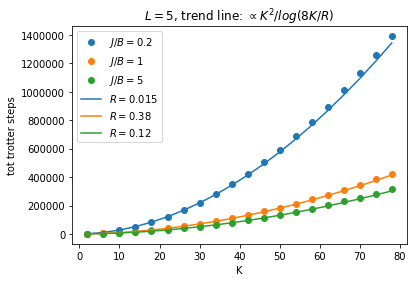

In [8]:
plt.title(f'$L={L}$, trend line: $\propto K^2 / log(8 K / R)$')
plt.plot(Klist, tts_lists_vsK, 'o', label = ' ')
plt.gca().set_prop_cycle(None)
for i, JvB in enumerate(JvBlist):
    R = Rfunc(L, JvB)
    fit = lambda K: K**2 / np.log(8 * K / R)
    plt.plot(Klist, fit(Klist)/fit(Klist[5])*tts_lists_vsK[5][i], label = f'$R = {R:.2}$')
    
h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, [f'$J/B = {JvB}$' for JvB in JvBlist] + l[3:] )
plt.xlabel('K')
plt.ylabel('tot trotter steps')